In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Считываем данные о заголовках:

empty_title_count = 0
doc_to_title = {}
with open('docs_titles.tsv') as f:
    next(f)
    for line in f:
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
            empty_title_count += 1
        else:
            title = data[1]
        doc_to_title[doc_id] = title

print('Number of titles =', len(doc_to_title))
print('Number of empty titles =', empty_title_count)
print('Examples:')
for _, title in zip(range(3), doc_to_title.values()):
    print('    ', title)

Number of titles = 28026
Number of empty titles = 32
Examples:
     ВАЗ 21213 | Замена подшипников ступицы | Нива
     Ваз 2107 оптом в Сочи. Сравнить цены, купить потребительские товары на Tiu.ru
     Купить ступица Лада калина2. Трансмиссия - переходные ступицы цена, замена, тюнинг.


# Анализ данных
громко сказано, кншн :D

In [3]:
# Посмотрим, из чего строятся заголовки:

import collections

counter = collections.Counter()
for title in doc_to_title.values():
    for symbol in title:
        counter[symbol] += 1
print(*counter.most_common(), sep = '\n')

(' ', 231840)
('о', 116687)
('а', 108891)
('и', 97876)
('е', 93772)
('н', 77139)
('т', 76931)
('р', 68968)
('с', 60524)
('к', 53239)
('в', 49027)
('л', 45806)
('м', 32252)
('д', 31969)
('п', 29434)
('у', 28814)
('ы', 24732)
('ь', 22652)
('я', 20265)
('г', 18462)
('б', 17632)
('й', 17166)
('з', 16953)
('-', 16666)
('.', 15277)
('ч', 13953)
('К', 11561)
('С', 10653)
('e', 10314)
('х', 9765)
(',', 8831)
('О', 8447)
('ц', 8251)
('a', 8215)
('r', 7905)
('i', 7744)
('ж', 7535)
('o', 7126)
('П', 7065)
('А', 6582)
('ш', 6514)
('n', 6453)
('t', 6216)
('ф', 6199)
('u', 6179)
(':', 6047)
('Р', 5971)
('В', 5726)
('1', 5447)
('И', 5385)
('0', 5161)
('Н', 4909)
('s', 4894)
('2', 4833)
('|', 4830)
('М', 4738)
('ю', 4670)
('Д', 4331)
('Т', 4308)
('l', 3830)
('?', 3818)
('Е', 3458)
('Л', 3064)
('Б', 3055)
('d', 2863)
('Ф', 2785)
('m', 2759)
(')', 2735)
('щ', 2667)
('(', 2627)
('Г', 2497)
('R', 2424)
('c', 2359)
('У', 2339)
('Ч', 2299)
('S', 2291)
('3', 2199)
('b', 2191)
('M', 2176)
('З', 2064)
('4', 20

Основные имеющие значения символы - буквы русского и английского алфавитов

# Извлечение признаков

In [4]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.metrics import pairwise_distances

In [5]:
stop_words = set(stopwords.words(["russian", "english"]))

In [6]:
stemmerR = SnowballStemmer("russian")
stemmerE = SnowballStemmer("english")

In [7]:
class Parser:
    """
    Тем или иным способом разбивает заголовок на слова
    Способ задается параметром pattern
    """
    
    def __init__(self, pattern='smart'):
        if pattern == 'simple':
            self.split_title = self.simple
        elif pattern == 'smart':
            self.split_title = self.smart
        elif pattern == 'smartest':
            self.split_title = self.smartest
        else:
            raise ValueError("unrecognized pattern: " + pattern)
    
    @staticmethod
    def simple(title):
        return title.split()
    
    @staticmethod
    def smart(title):
        title = title.lower()
        words = [stemmerR.stem(stemmerE.stem(word)) for word in re.sub('[^a-zа-я0-9]', ' ', title).split() 
                 if not word in stop_words]
        return [word for word in words if not word in stop_words]
            
    def transform(self, titles_dict):
        words_dict = {}
        for ID, title in titles_dict.items():
            words_dict[ID] = self.split_title(title)
        return words_dict

In [1]:
class Collecter:
    """
    Тем или иным способом собирает фичи из заголовков
    Способ задается параметром features
    """

    def __init__(self, doc_to_title, features='tf-idf+groups'):

        self.feat_type = np.float
        
        features = features.split('+')
        if features[0] == 'simple':
            self.doc_to_vec = doc_to_title
            self.n_features = 15
            self.extract_features = self.jaccard
        elif features[0] == 'tf-idf':
            doc_to_title[0] = ''
            self.doc_to_vec = TfidfVectorizer().fit_transform(
                [' '.join(doc_to_title[i]) for i in range(len(doc_to_title))])
            self.n_features = 20
            if 'groups' in features:
                self.n_features *= 2
                self.extract_features = self.cosine_plus
            else: 
                self.extract_features = self.cosine
        else:
            raise ValueError("unrecognized features type: " + features[0])
            
    def jaccard(self, group):
        X = np.empty(shape=(group.size, self.n_features), dtype=self.feat_type)
        
        for i, doc_ID in enumerate(group):
            dist = np.empty(shape=(group.size, ), dtype=self.feat_type)
            vec = set(self.doc_to_vec[doc_ID])
            for j, doc_j in enumerate(group):
                if doc_ID == doc_j:
                    dist[j] = 0
                else:
                    vec_j = set(self.doc_to_vec[doc_j])
                    intersec = len(vec.intersection(vec_j))
                    if intersec > 0:
                        dist[j] = intersec/(len(vec) + len(vec_j) - intersec)
                    else:
                        dist[j] = 0
            X[i] = np.sort(dist)[-self.n_features:]

        return X
    
    def cosine(self, group):
        X = np.empty(shape=(group.size, self.n_features), dtype=self.feat_type)
        for i, title in enumerate(pairwise_distances(self.doc_to_vec[group], metric='cosine')):
            X[i] = sorted(title)[1:self.n_features + 1]
            
        return X
    
    def cosine_plus(self, group):
        n = self.n_features//2
        X = np.empty(shape=(group.size, self.n_features), dtype=self.feat_type)
        for i, title in enumerate(pairwise_distances(self.doc_to_vec[group], metric='cosine')):
            X[i, :n] = sorted(title)[1:n + 1]
        X[:, n:] = np.mean(X[:, :n], axis=0)
        X[:, :n] /= X[:, n:]
        
        return X
            
    def collect_from(self, file):
        data = pd.read_csv(file)
        groups = data.groupby('group_id')

        if 'target' in data.columns:
            X = np.empty(shape=(data.shape[0], self.n_features), dtype=self.feat_type)
            y = np.empty(shape=(data.shape[0], ), dtype=bool)
            group_ids = np.empty(shape=(data.shape[0], ), dtype=int)

            i = 0
            for group_id, group_indx in groups.groups.items():
                j = i + group_indx.size
                group = data.iloc[group_indx]
                group_ids[i:j] = group_id
                y[i:j] = group.target
                X[i:j] = self.extract_features(group.doc_id)
                i = j

            return X, y, group_ids
        else:
            X = np.empty(shape=(data.shape[0], self.n_features), dtype=self.feat_type)
            pair_ids = np.empty(shape=(data.shape[0], ), dtype=int)

            i = 0
            for group_id, group_indx in groups.groups.items():
                j = i + group_indx.size
                group = data.iloc[group_indx]
                pair_ids[i:j] = group.pair_id
                X[i:j] = self.extract_features(group.doc_id)
                i = j

            return X, pair_ids


# Обучение

In [8]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC

In [26]:
def th_def(cls, X):
    cls.predict(X)
def th_pred(cls, X):
    return cls.predict(X)
def th_pred_proba(cls, X):
    return cls.predict_proba(X)[:, 1]

def KFold_score(cls, X, y, groups, th, pred, k=5):
    result = 0
    for train, test in GroupKFold(n_splits=k).split(X, y, groups):
        cls.fit(X[train], y[train])
        result += f1_score(y[test], pred(cls, X[test]) > th)
    return result / k

def best_th(cls, X, y, groups, pred, k=5):
    space = np.linspace(0.1, 0.9, 25)
    result = np.zeros_like(space)
    for train, test in GroupKFold(n_splits=k).split(X, y, groups):
        cls.fit(X[train], y[train])
        predict = pred(cls, X[test])
        
        for i, th in enumerate(space):
            result[i] += f1_score(y[test], predict > th)

    best = np.argmax(result)
    return space[best], result[best] / k

Первые шаги:

In [20]:
# 1
# Фичи выбираются как максимальные меры Жаккарда между заголовками документа, 
# разбитыми по пробельным символам

parser = Parser(pattern='simple')
vec = parser.transform(doc_to_title)
collecter = Collecter(vec, features='simple')
X_train, y_train, groups_train = collecter.collect_from('train_groups.csv')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

cls = LogisticRegression(solver='lbfgs', max_iter=1000)
th, f1 = best_th(cls, X_train, y_train, groups_train, th_pred_proba)
cls.fit(X_train, y_train)
th, f1

(0.30000000000000004, 0.6314784298147564)

In [27]:
# 2
# Фичи выбираются как максимальные меры Жаккарда между заголовками документа.
# Заголовки разбиваются на слова, подвергающиеся некоторой обработке

parser = Parser()
vec = parser.transform(doc_to_title)
collecter = Collecter(vec, features='simple')
X_train, y_train, groups_train = collecter.collect_from('train_groups.csv')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

cls = LogisticRegression(solver='lbfgs', max_iter=1000)
th, f1 = best_th(cls, X_train, y_train, groups_train, th_pred_proba)
cls.fit(X_train, y_train)
th, f1

(0.26666666666666666, 0.6961116782012919)

In [69]:
# 3
# Фичи выбираются как минимальные косинусные расстояния между заголовками расстояния.
# Заголовки представляются в векторном виде с применением tf-idf преобразования

parser = Parser()
vec = parser.transform(doc_to_title)
collecter = Collecter(vec, features='tf-idf')
X_train, y_train, groups_train = collecter.collect_from('train_groups.csv')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

cls = LogisticRegression(solver='lbfgs', max_iter=1000)
th, f1 = best_th(cls, X_train, y_train, groups_train, th_pred_proba)
cls.fit(X_train, y_train)
th, f1

(0.30000000000000004, 0.7265307521177471)

In [34]:
# 4
# Пробуем обучиться на разных моделях:

In [12]:
parser = Parser()
vec = parser.transform(doc_to_title)

In [37]:
collecter = Collecter(vec, features='tf-idf')
X_train, y_train, groups_train = collecter.collect_from('train_groups.csv')

In [38]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [39]:
cls = LogisticRegression(solver='lbfgs', max_iter=1000)
best_th(cls, X_train, y_train, groups_train, th_pred_proba)

(0.30000000000000004, 0.7265307521177471)

In [40]:
cls = LinearRegression()
best_th(cls, X_train, y_train, groups_train, th_pred)

(0.3666666666666667, 0.725401789308459)

In [41]:
cls = SVC(C=1.0, degree=3, kernel='poly', probability=True, gamma='auto')
best_th(cls, X_train, y_train, groups_train, th_pred_proba)

(0.23333333333333334, 0.7081555486729109)

In [42]:
cls = RandomForestClassifier(n_estimators=10, max_depth=4)
best_th(cls, X_train, y_train, groups_train, th_pred_proba)

(0.33333333333333337, 0.7262446735365861)

Поподробнее остановимся на деревьях:

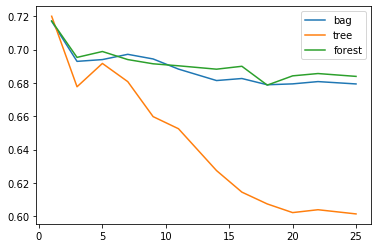

In [43]:
cv = GroupKFold(n_splits=5)
depths = np.linspace(1, 25, 12, dtype=int)

model = DecisionTreeClassifier(random_state=0)
_, tree_valid_scores = validation_curve(
    model, X_train, y_train, groups=groups_train, 
    param_name='max_depth', 
    param_range=depths, 
    scoring=make_scorer(f1_score), cv=cv, 
    n_jobs=-1)

model = BaggingClassifier(DecisionTreeClassifier(), 
                          n_estimators=50, random_state=0)
_, bag_valid_scores = validation_curve(
    model, X_train, y_train, groups=groups_train, 
    param_name='base_estimator__max_depth', 
    param_range=depths, 
    scoring=make_scorer(f1_score), cv=cv, 
    n_jobs=-1)

model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1)
_, forest_valid_scores = validation_curve(
    model, X_train, y_train, groups=groups_train, 
    param_name='max_depth', 
    param_range=depths, 
    scoring=make_scorer(f1_score), cv=cv, 
    n_jobs=1)

plt.plot(depths, bag_valid_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_valid_scores.mean(axis=1), label='tree')
plt.plot(depths, forest_valid_scores.mean(axis=1), label='forest')
plt.legend()

Ну и апофеоз всего этого - объединим результаты показавших себя лучше прочих моделей:

In [20]:
class combined_cls:
    def __init__(self):
        self.cls1 = LogisticRegression(solver='lbfgs', max_iter=1000, C=10.0)
        self.cls2 = LinearRegression()
        self.cls3 = RandomForestClassifier(n_estimators=50, max_depth=5, 
                                           random_state=0, n_jobs=-1)
        # self.cls4 = SVC(C=1.0, degree=3, kernel='poly', probability=True, gamma='auto')
        self.cls = LinearRegression()
        
    def fit(self, X, y):
        self.cls1.fit(X, y)
        self.cls2.fit(X, y)
        self.cls3.fit(X, y)
        # self.cls4.fit(X, y)
        self.cls.fit(np.array([
            self.cls1.predict_proba(X)[:, 1],
            self.cls2.predict(X), 
            self.cls3.predict_proba(X)[:, 1]
            # , self.cls4.predict_proba(X)[:, 1]
        ]).T, y)
        
    def predict(self, X):
        return self.cls.predict(np.array([
            self.cls1.predict_proba(X)[:, 1],
            self.cls2.predict(X), 
            self.cls3.predict_proba(X)[:, 1]
            # , self.cls4.predict_proba(X)[:, 1]
        ]).T)


In [80]:
cls = combined_cls()
th, f1 = best_th(cls, X_train, y_train, groups_train, th_pred)
cls.fit(X_train, y_train)
th, f1

(0.33333333333333337, 0.7241998082544692)

In [10]:
# 5
# добавим фичи, характеризующие группу - средние от старых в пределах группы
# другие варианты рассматривались, но до ума их довести не получилось

In [71]:
collecter = Collecter(vec)
X_train, y_train, groups_train = collecter.collect_from('train_groups.csv')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
cls = combined_cls()
th, f1 = best_th(cls, X_train, y_train, groups_train, th_pred)
cls.fit(X_train, y_train)
th, f1

(0.4, 0.7533389073648966)

In [27]:
# то же, но фичи скалированны в группах

collecter = Collecter(vec)
X_train, y_train, groups_train = collecter.collect_from('train_groups.csv')
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
cls = combined_cls()
th, f1 = best_th(cls, X_train, y_train, groups_train, th_pred)
cls.fit(X_train, y_train)
th, f1

(0.4, 0.7578947637814246)

# Предсказание

In [22]:
def save_result(pair_ids, predict, filename='predict.csv'):
    with open(filename, 'w') as f:
        print('pair_id,target', file = f)
        for pair_id, target in zip(pair_ids, predict):
            print(pair_id, int(target), sep=',', file=f)

In [23]:
X_test, pair_ids = collecter.collect_from('test_groups.csv')
X_test = scaler.transform(X_test)
predict = cls.predict(X_test) > th
save_result(pair_ids, predict, '8.csv')

EOF